In [1]:
%load_ext autoreload
%autoreload 2
from targets.conditional_density_estimation_target import *

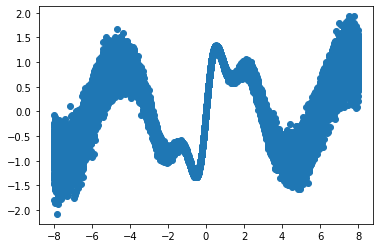

In [2]:
target = Wave()
theta = target.sample_prior(50000)
x = target.simulate(theta)
fig = plt.scatter(theta.squeeze(-1).numpy(), x.squeeze(-1).numpy())
plt.show()

torch.Size([1])


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.47331893, 0.49331895, 0.51331896, 0.53331894, 0.5533189 ,
        0.57331896, 0.59331894, 0.6133189 , 0.63331896, 0.65331894,
        0.6733189 , 0.69331896, 0.71331894, 0.7333189 , 0.7533189 ,
        0.77331895, 0.7933189 , 0.8133189 , 0.83331895, 0.8533189 ,
        0.8733189 , 0.89331895, 0.91331893, 0.9333189 , 0.95331895,
        0.97331893, 0.9933189 , 1.0133189 , 1.0333189 , 1.053319  ,
        1.073319  , 1.0933189 , 1.1133189 , 1.1333189 , 1.1533189 ,
        1.173319  , 1.193319  , 1.213319  , 1.2333189 , 1.2533189 ,
        1.2733189 , 1.293319  , 1.313319  , 1.333319  , 1.3533189 ,
        1.3733189 , 1.3933189 , 1.413319  , 1.433319  , 1.453319  ,
        1.4733189 ], dtype=float32),
 <BarContainer object of 50 artists>)

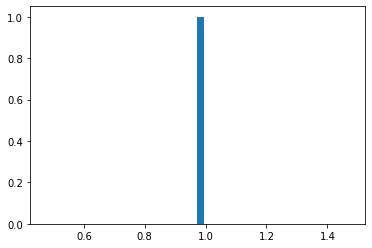

In [8]:
theta_0 = torch.tensor([2])
print(theta_0.shape)
num_observations = 1
x_0 = target.simulate(theta_0.unsqueeze(0).repeat(num_observations,1))
plt.figure()
plt.hist(x_0.detach().numpy(), bins =50)

In [9]:
from models_dif import ConditionalDIFDensityEstimator
architecture = ConditionalDIFDensityEstimator
K = 1
hidden_dimensions = [5,5]
from prettytable import PrettyTable

def count_parameters():
    model = architecture(x, theta,K,hidden_dimensions)
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
number_param = count_parameters()
print(number_param)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| w.f.0.weight |     10     |
|  w.f.0.bias  |     5      |
| w.f.2.weight |     25     |
|  w.f.2.bias  |     5      |
| w.f.4.weight |     5      |
|  w.f.4.bias  |     1      |
| T.f.0.weight |     5      |
|  T.f.0.bias  |     5      |
| T.f.2.weight |     25     |
|  T.f.2.bias  |     5      |
| T.f.4.weight |     10     |
|  T.f.4.bias  |     2      |
+--------------+------------+
Total Trainable Params: 103
103


In [5]:
import copy 
def metropolis_adjusted_langevin_step(current_model,data,tau):
    
    #evaluate current model
    current_model.zero_grad()
    log_prob = -current_model.loss(data)*data.shape[0]
    log_prob.backward()
    print(log_prob)
    
    #copy model
    copy_model = copy.deepcopy(current_model)
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2))
            
    #compute copy_loss
    copy_model.zero_grad()
    copy_log_prob = -copy_model.loss(data)*data.shape[0]
    copy_log_prob.backward()
    print(copy_log_prob) 
    
    #compute proposal densities
    with torch.no_grad():
        log_ratio = 0
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        #acceptation probability
        acceptance_log_prob = copy_log_prob - log_prob + log_ratio
        print(torch.exp(acceptance_log_prob))
        if torch.rand(1)<torch.exp(acceptance_log_prob):
            print('accepted')
            return copy_model
        else:
            print('denied')
            return current_model

    return copy_model


In [6]:
from IPython.display import clear_output
theta_linspace = torch.linspace(-8.,8.,100)
x_linspace = torch.linspace(-2.,2.,100)
grid_theta,grid_x = torch.meshgrid(theta_linspace, x_linspace, indexing = 'ij')

trained_model = ConditionalDIFDensityEstimator(x, theta, K, hidden_dimensions)
trained_model.train(500,10000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:07<00:00,  1.10s/it, loss = 0.155703 ; device: cpu]


In [11]:
current_model = trained_model
current_theta = torch.randn([1])
current_theta.requires_grad = True
log_prob = -current_model.loss(x, theta)*x.shape[0] + torch.sum(current_model.log_density(x_0, current_theta.unsqueeze(0).repeat(x_0.shape[0],1)))
log_prob.backward()

for i in range(20000):
    tau = 0.0001/(x.shape[0])
    
    #copy model
    copy_theta = copy.deepcopy(current_theta)
    with torch.no_grad():
        copy_theta.data = current_theta.data + tau*current_theta.grad + torch.randn_like(current_theta.data)*((2*tau)**(1/2))
    copy_model = copy.deepcopy(current_model)
    for param, copy_param in zip(current_model.parameters(), copy_model.parameters()):
        with torch.no_grad():
            copy_param.data= param.data+tau*param.grad + torch.randn_like(param.data)*((2*tau)**(1/2))
            
    #compute copy_loss
    copy_model.zero_grad()
    copy_log_prob = -copy_model.loss(x, theta)*x.shape[0] + torch.sum(copy_model.log_density(x_0, copy_theta.unsqueeze(0).repeat(x_0.shape[0],1)))
    copy_log_prob.backward()
    clear_output(wait = True)
    plt.figure()
    with torch.no_grad():
        density = current_model.log_density(grid_x.unsqueeze(-1), grid_theta.unsqueeze(-1))
        plt.pcolormesh(grid_theta, grid_x,torch.exp(density).detach().numpy())
        plt.show()
    print(log_prob)
    print(copy_log_prob) 
    
    #compute proposal densities
    with torch.no_grad():
        log_ratio = torch.sum(torch.square(copy_theta - current_theta - tau*current_theta.grad))/(4*tau)-torch.sum(torch.square(current_theta - copy_theta - tau*copy_theta.grad))/(4*tau)
        for param, new_param in zip(current_model.parameters(),copy_model.parameters()):
            log_ratio -= torch.sum(torch.square(param - new_param - tau*new_param.grad))/(4*tau)
            log_ratio += torch.sum(torch.square(new_param - param - tau*param.grad))/(4*tau)
        #acceptation probability
        acceptance_log_prob = copy_log_prob - log_prob + log_ratio
        print(torch.exp(acceptance_log_prob))
        if torch.rand(1)<torch.exp(acceptance_log_prob):
            print('accepted')
            current_model = copy_model
            log_prob = copy_log_prob
            current_theta = copy_theta
    

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>